In [1]:
import logging

import joblib
import numpy as np
import pandas as pd

FORMAT = "%(asctime)s %(message)s"
logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")


def load_data():
    try:
        path = "/Users/edeno/Downloads/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        position = np.asarray(position_info.linear_position).astype(float)
        position2D = np.asarray(position_info[["nose_x", "nose_y"]]).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)
    except FileNotFoundError:
        path = "/cumulus/edeno/non_local_paper/notebooks/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        position = np.asarray(position_info.linear_position).astype(float)
        position2D = np.asarray(position_info[["nose_x", "nose_y"]]).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)

    return is_ripple, spikes, position, speed, env, time, position2D


is_ripple, spikes, position, speed, env, time, position2D = load_data()
track_graph = env.track_graph
edge_order = env.edge_order
edge_spacing = env.edge_spacing

29-Jan-25 17:18:17 Cupy is not installed or GPU is not detected. Ignore this message if not using GPU
/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Discrete transition: [[0.9   0.1  ]
 [0.032 0.968]]
Iter: 0, Marginal Likelihood: -1934897.5
Iter: 1, Marginal Likelihood: -1910847.875
Iter: 2, Marginal Likelihood: -1888577.5
Iter: 3, Marginal Likelihood: -1883138.5
Iter: 4, Marginal Likelihood: -1882212.0
Iter: 5, Marginal Likelihood: -1881616.25
Iter: 6, Marginal Likelihood: -1881381.0
Iter: 7, Marginal Likelihood: -1881194.125


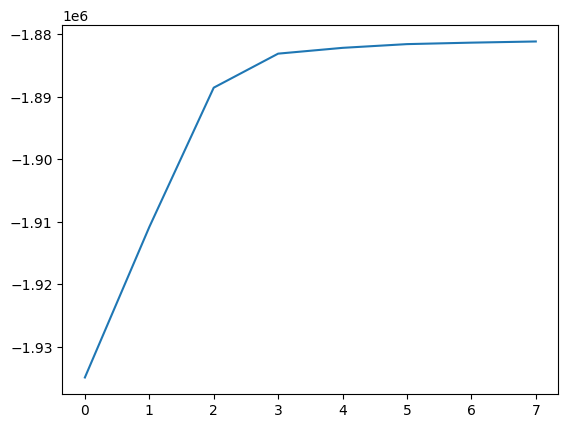

In [225]:
import jax.numpy as jnp
import jax.scipy.stats
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

from non_local_detector.continuous_state_transitions import (
    Discrete,
    RandomWalk,
)
from non_local_detector.core import (
    check_converged,
    chunked_filter_smoother,
)
from non_local_detector.discrete_state_transitions import (
    _estimate_discrete_transition,
)
from non_local_detector.environment import Environment

EPS = 1e-15


def estimate_place_fields_kde(spike_counts, position_index, env, kde_var=np.sqrt(12.5), weights=None):

    if weights is None:
        weights = np.ones_like(position_index)

    place_bin_center_ind_to_node = np.asarray(env.place_bin_centers_nodes_df_.node_id)
    n_place_bins = env.place_bin_centers_.size
    gaussian_dist = np.zeros((n_place_bins, n_place_bins))
    gaussian = multivariate_normal(mean=0.0, cov=kde_var)

    for bin_ind1, node1 in enumerate(place_bin_center_ind_to_node):
        for bin_ind2, node2 in enumerate(place_bin_center_ind_to_node):
            try:
                gaussian_dist[bin_ind1, bin_ind2] = gaussian.pdf(
                    env.distance_between_nodes_[node1][node2]
                )
            except KeyError:
                # bins not on track interior will be -1 and not in distance
                # between nodes
                gaussian_dist[bin_ind1, bin_ind2] = EPS

    gaussian_dist = gaussian_dist[:, position_index]
    gaussian_dist /= gaussian_dist.sum(axis=1, keepdims=True)
    gaussian_dist *= weights

    weighted_occupancy = np.sum(gaussian_dist, axis=1) + EPS
    return np.stack(
        [
            (gaussian_dist @ neuron_count) / weighted_occupancy
            for neuron_count in spike_counts.T
        ],
        axis=1,
    )


def estimate_place_fields(
    spike_counts, position_index, occupancy_count, weights=None, sampling_frequency=500
):
    if weights is None:
        weights = np.ones_like(position_index)
    estimated_place_fields = []
    n_position_bins = occupancy_count.shape[0]

    for count in spike_counts.T:
        # neuron_count = np.bincount(
        #     position_index[count > 0],
        #     minlength=n_position_bins,
        #     weights=weights[count > 0],
        # )
        neuron_count = np.bincount(
            position_index, minlength=n_position_bins, weights=weights * count
        )
        estimated_place_fields.append(
            np.where(
                occupancy_count == 0,
                EPS,
                (neuron_count + EPS) / (occupancy_count + EPS),
            ),
        )

    return jnp.clip(
        np.stack(estimated_place_fields, axis=1),
        a_min=EPS,
        a_max=125 / sampling_frequency,
    )


def estimate_log_likelihood(
    spike_counts, position_index, occupancy_count, env, weights=None
):

    n_time, n_position_bins = spike_counts.shape[0], occupancy_count.shape[0]
    # estimated_position_rates = estimate_place_fields(
    #     spike_counts, position_index, occupancy_count, weights
    # )
    estimated_position_rates = estimate_place_fields_kde(
        spike_counts, position_index, env, kde_var=np.sqrt(12.5), weights=weights
    )
    estimated_local_rates = estimated_position_rates[position_index]

    local_log_likelihood = jnp.sum(
        jax.scipy.stats.poisson.logpmf(spike_counts, estimated_local_rates), axis=1
    )
    non_local_log_likelihood = jnp.zeros((n_time, n_position_bins))
    for count, rate in zip(spike_counts.T, estimated_position_rates.T, strict=False):
        non_local_log_likelihood += jax.scipy.stats.poisson.logpmf(
            np.expand_dims(count, axis=1),
            jnp.expand_dims(rate, axis=0),
        )

    log_likelihood = jnp.concatenate(
        [local_log_likelihood[:, None], non_local_log_likelihood], axis=1
    )

    return log_likelihood, estimated_position_rates


def run_EM(
    time,
    position,
    spike_counts,
    weights,
    track_graph,
    edge_order,
    edge_spacing,
    place_bin_size=2.0,
    max_iter=30,
    estimate_initial_conditions=False,
    estimate_discrete_transition=False,
    estimate_local_place_fields=False,
):
    # spike_counts = np.stack(
    #     [get_spikecount_per_time_bin(times, time) for times in spike_times], axis=1
    # )

    env = Environment(
        place_bin_size=place_bin_size,
        track_graph=track_graph,
        edge_order=edge_order,
        edge_spacing=edge_spacing,
    ).fit_place_grid(position[:, None])
    n_position_bins = env.place_bin_centers_.shape[0]
    position_index = np.digitize(position, env.place_bin_edges_[:, 0][1:-1])
    occupancy_count = np.bincount(
        position_index, minlength=n_position_bins, weights=weights
    )

    initial_conditions = np.zeros((n_position_bins + 1,))

    # State 1 is local - start in local state
    # initial_conditions[1:] are the non-local state initial conditions
    initial_conditions[0] = 1.0

    # Local -> Local, Local -> Non-Local, Non-Local -> Local, Non-Local -> Non-Local
    prob_local_non_local = 1e-1
    discrete_transition_matrix = np.array(
        [
            [1 - prob_local_non_local, prob_local_non_local],
            [1 - 0.968, 0.968],
        ]
    )

    continuous_transition_matrix = np.zeros((n_position_bins + 1, n_position_bins + 1))
    continuous_transition_matrix[0, 0] = (
        Discrete().make_state_transition().squeeze()
    )  # Local -> Local
    continuous_transition_matrix[0, 1:] = (
        np.ones((n_position_bins,)) / n_position_bins
    )  # Local -> Non-Local
    continuous_transition_matrix[1:, 0] = (
        np.ones((n_position_bins,)) / n_position_bins
    )  # Non-local -> Local, consider random walk centered around the current position
    continuous_transition_matrix[1:, 1:] = RandomWalk(
        movement_var=6.0
    ).make_state_transition(
        environments=[env]
    )  # Non-Local -> Non-Local
    continuous_transition_matrix = continuous_transition_matrix / np.sum(
        continuous_transition_matrix, axis=1, keepdims=True
    )  # Normalize

    # State 0 is local
    state_ind = np.zeros((n_position_bins + 1,), dtype=int)
    state_ind[1:] = 1

    # Combine the continuous and discrete transition matrices

    print(f"Discrete transition: {discrete_transition_matrix}")
    transition_matrix = (
        continuous_transition_matrix
        * discrete_transition_matrix[np.ix_(state_ind, state_ind)]
    )
    transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

    # Initial conditions
    weights = np.ones_like(time)
    marginal_likelihoods = []
    is_converged = False
    iter = 0

    position_rates_iter = []
    local_prob_iter = []

    while not is_converged and iter < max_iter:
        log_likelihood, estimated_position_rates = estimate_log_likelihood(
            spike_counts, position_index, occupancy_count, env, weights
        )
        position_rates_iter.append(estimated_position_rates)

        (
            acausal_posterior,
            acausal_state_probabilities,
            marginal_likelihood,
            causal_state_probabilities,
            predictive_state_probabilities,
            _,
        ) = chunked_filter_smoother(
            time,
            state_ind,
            initial_conditions,
            transition_matrix,
            None,
            None,
            cache_log_likelihoods=False,
            log_likelihoods=log_likelihood,
        )
        local_prob_iter.append(causal_state_probabilities[:, 0])
        marginal_likelihoods.append(marginal_likelihood)

        try:
            is_converged, _ = check_converged(
                marginal_likelihoods[-1], marginal_likelihoods[-2]
            )
        except IndexError:
            pass

        print(f"Iter: {iter}, Marginal Likelihood: {marginal_likelihoods[-1]}")
        if is_converged:
            break

        iter += 1

        if estimate_local_place_fields:
            weights = acausal_state_probabilities[:, 0]
        if estimate_initial_conditions:
            initial_conditions = acausal_posterior[0]
        if estimate_discrete_transition:
            (
                discrete_transition_matrix,
                _,
            ) = _estimate_discrete_transition(
                causal_state_probabilities,
                predictive_state_probabilities,
                acausal_state_probabilities,
                discrete_transition_matrix,
                discrete_transition_coefficients=None,
                discrete_transition_design_matrix=None,
                transition_concentration=1.5,
                transition_stickiness=np.array([100, 31]),
                transition_regularization=1e-10,
            )
            transition_matrix = (
                continuous_transition_matrix
                * discrete_transition_matrix[np.ix_(state_ind, state_ind)]
            )
            transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

    return (
        initial_conditions,
        continuous_transition_matrix,
        discrete_transition_matrix,
        state_ind,
        env,
        estimated_position_rates,
        log_likelihood,
        acausal_posterior,
        acausal_state_probabilities,
        marginal_likelihoods,
        is_converged,
        position_rates_iter,
        local_prob_iter,
    )


weights = np.ones_like(time)
(
    initial_conditions,
    continuous_transition_matrix,
    discrete_transition_matrix,
    state_ind,
    env,
    estimated_position_rates,
    log_likelihood,
    acausal_posterior,
    acausal_state_probabilities,
    marginal_likelihoods,
    is_converged,
    position_rates_iter,
    local_prob_iter,
) = run_EM(
    time,
    position,
    spikes,
    weights,
    track_graph,
    edge_order,
    edge_spacing,
    max_iter=10,
    place_bin_size=2.0,
    estimate_initial_conditions=True,
    estimate_discrete_transition=True,
    estimate_local_place_fields=True,
)

plt.figure()
plt.plot(marginal_likelihoods)

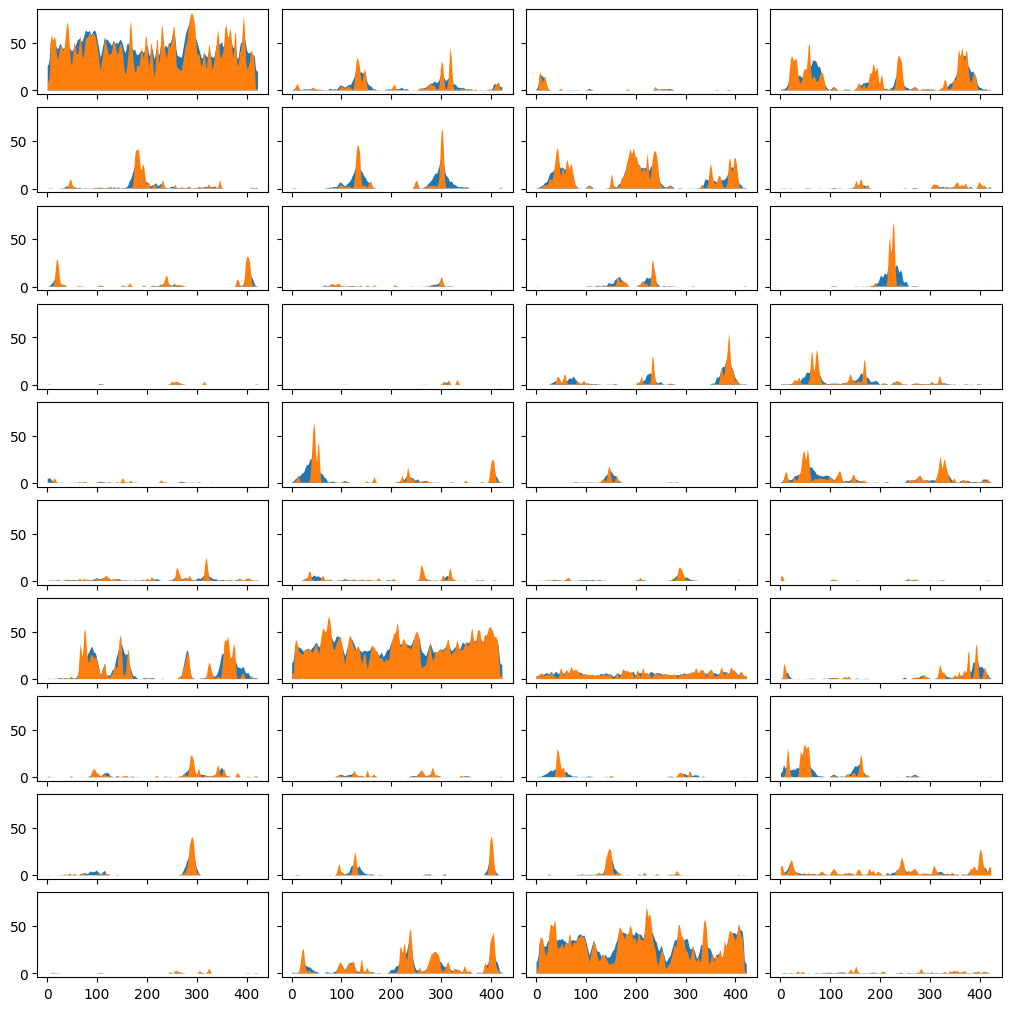

In [226]:
fig, axes = plt.subplots(
    10, 4, figsize=(10, 10), sharex=True, sharey=True, constrained_layout=True
)

for neuron_ind, ax in enumerate(axes.flat):
    ax.fill_between(
        env.place_bin_centers_.squeeze(),
        position_rates_iter[0][:, neuron_ind] * 500,
    )
    ax.fill_between(
        env.place_bin_centers_.squeeze(),
        position_rates_iter[-1][:, neuron_ind] * 500,
    )

In [220]:
discrete_transition_matrix

array([[9.99999887e-01, 1.13415024e-07],
       [3.50545210e-01, 6.49454790e-01]])

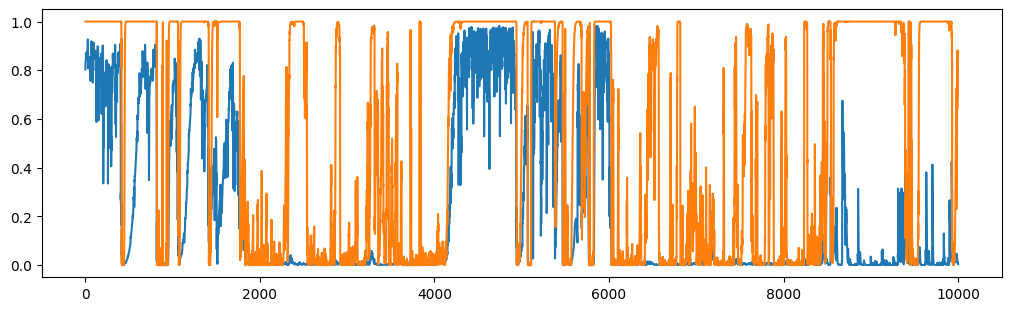

In [222]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3), constrained_layout=True)
ax.plot(local_prob_iter[0][100_000:110_000])
ax.plot(local_prob_iter[-1][100_000:110_000])

In [223]:
from non_local_detector.model_checking.posterior_consistency import (
    posterior_consistency_hpd_overlap,
    posterior_consistency_kl_divergence,
)

kl_div = posterior_consistency_kl_divergence(
    posterior=acausal_posterior, likelihood=np.exp(log_likelihood)
)
hpd_overlap = posterior_consistency_hpd_overlap(
    posterior=acausal_posterior, likelihood=np.exp(log_likelihood)
)

(22406.082875307, 22414.082875307)

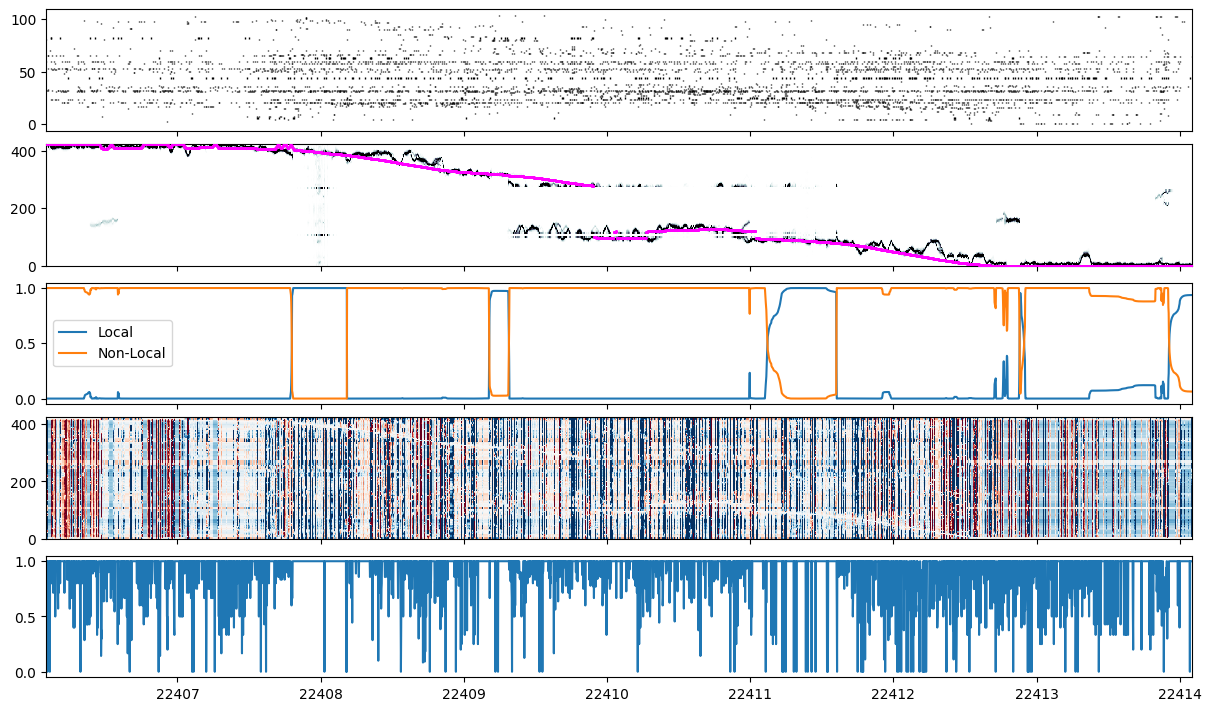

In [224]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(12, 7), sharex=True, constrained_layout=True)

spike_time_ind, spike_cell_ind = np.nonzero(spikes)
spike_times = [
    time[spike_time_ind[spike_cell_ind == i]] for i in range(spikes.shape[1])
]
sort_ind = np.argsort(np.argmax(estimated_position_rates, axis=0))
spike_times = [spike_times[i] for i in sort_ind]

time_slice = slice(time[0] + 17.0, time[0] + 25.0)
is_time_slice = (time >= time_slice.start) & (time <= time_slice.stop)

t, x = np.meshgrid(time[is_time_slice], env.place_bin_centers_)
conditional_non_local_acausal_posterior = acausal_posterior[is_time_slice, 1:]
conditional_non_local_acausal_posterior /= np.nansum(
    conditional_non_local_acausal_posterior, axis=1
)[:, np.newaxis]

axes[0].eventplot(
    [
        neuron_spike_times[
            (neuron_spike_times >= time_slice.start)
            & (neuron_spike_times <= time_slice.stop)
        ]
        for neuron_spike_times in spike_times
    ],
    colors="k",
    linewidths=1,
    rasterized=True,
)
axes[1].pcolormesh(
    t,
    x,
    conditional_non_local_acausal_posterior.T,
    vmin=0.0,
    vmax=0.1,
    rasterized=True,
    cmap="bone_r",
)
axes[1].scatter(
    time[is_time_slice],
    position[is_time_slice],
    s=1,
    color="magenta",
    rasterized=True,
    zorder=10,
)
axes[2].plot(
    time[is_time_slice], acausal_state_probabilities[is_time_slice, 0], label="Local"
)
axes[2].plot(
    time[is_time_slice],
    acausal_state_probabilities[is_time_slice, 1],
    label="Non-Local",
)
axes[2].legend()


axes[3].pcolormesh(
    t,
    x,
    (
        log_likelihood[is_time_slice, 1:]
        - log_likelihood[is_time_slice, 0][:, np.newaxis]
    ).T,
    cmap="RdBu_r",
    rasterized=True,
    vmin=-3,
    vmax=3,
)
axes[4].plot(time[is_time_slice], hpd_overlap[is_time_slice])

plt.xlim((time_slice.start, time_slice.stop))

(22406.082875307, 22406.582875307)

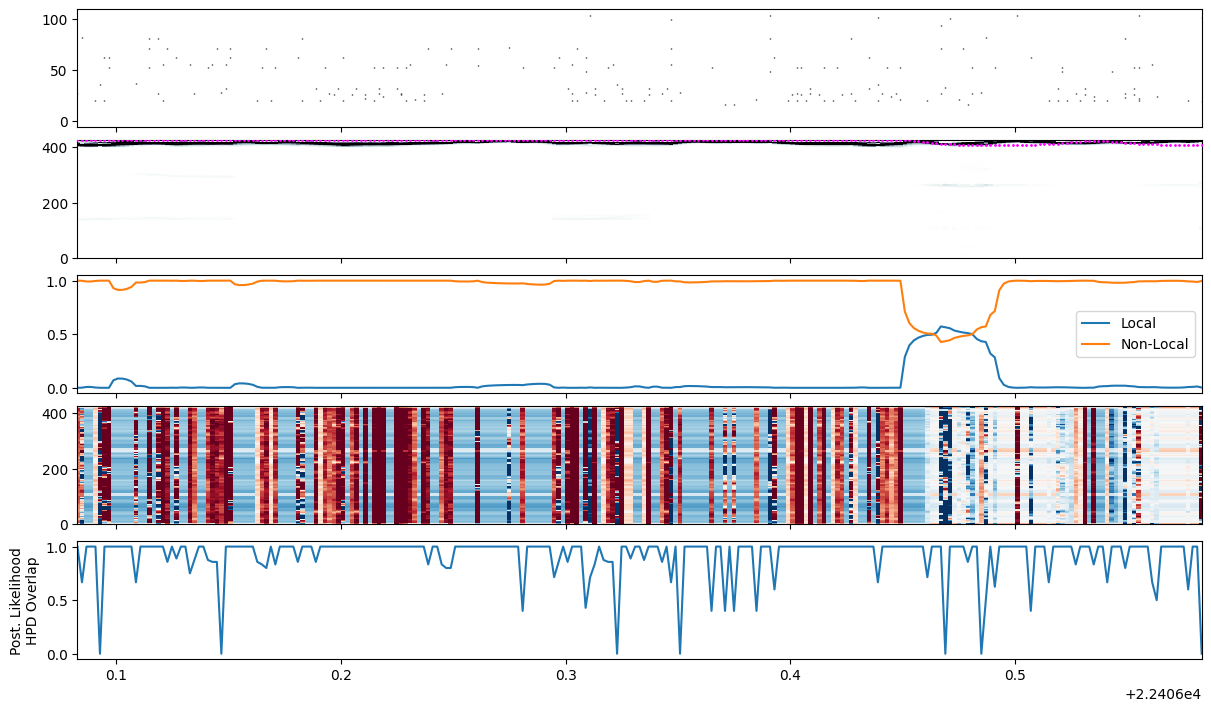

In [127]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(12, 7), sharex=True, constrained_layout=True)

spike_time_ind, spike_cell_ind = np.nonzero(spikes)
spike_times = [
    time[spike_time_ind[spike_cell_ind == i]] for i in range(spikes.shape[1])
]
sort_ind = np.argsort(np.argmax(estimated_position_rates, axis=0))
spike_times = [spike_times[i] for i in sort_ind]

time_slice = slice(time[0] + 17.0, time[0] + 17.5)
is_time_slice = (time >= time_slice.start) & (time <= time_slice.stop)

t, x = np.meshgrid(time[is_time_slice], env.place_bin_centers_)
conditional_non_local_acausal_posterior = acausal_posterior[is_time_slice, 1:]
conditional_non_local_acausal_posterior /= np.nansum(
    conditional_non_local_acausal_posterior, axis=1
)[:, np.newaxis]

axes[0].eventplot(
    [
        neuron_spike_times[
            (neuron_spike_times >= time_slice.start)
            & (neuron_spike_times <= time_slice.stop)
        ]
        for neuron_spike_times in spike_times
    ],
    colors="k",
    linewidths=1,
    rasterized=True,
)
axes[1].pcolormesh(
    t,
    x,
    conditional_non_local_acausal_posterior.T,
    vmin=0.0,
    vmax=0.1,
    rasterized=True,
    cmap="bone_r",
)
axes[1].scatter(
    time[is_time_slice],
    position[is_time_slice],
    s=1,
    color="magenta",
    rasterized=True,
    zorder=10,
)
axes[2].plot(
    time[is_time_slice], acausal_state_probabilities[is_time_slice, 0], label="Local"
)
axes[2].plot(
    time[is_time_slice],
    acausal_state_probabilities[is_time_slice, 1],
    label="Non-Local",
)
axes[2].legend()


axes[3].pcolormesh(
    t,
    x,
    (
        log_likelihood[is_time_slice, 1:]
        - log_likelihood[is_time_slice, 0][:, np.newaxis]
    ).T,
    cmap="RdBu_r",
    rasterized=True,
    vmin=-3,
    vmax=3,
)
axes[4].plot(time[is_time_slice], hpd_overlap[is_time_slice])
axes[4].set_ylabel("Post. Likelihood\nHPD Overlap")

plt.xlim((time_slice.start, time_slice.stop))

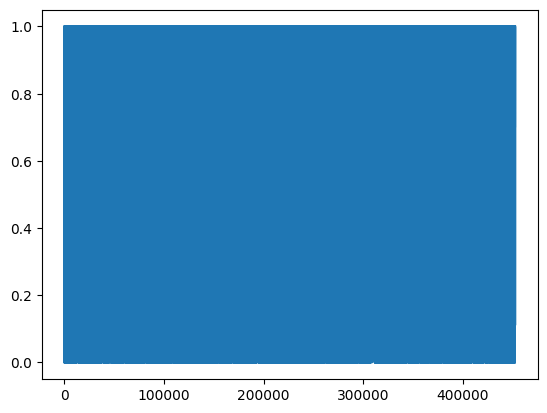

In [108]:
plt.plot(hpd_overlap)

In [ ]:
place_bin_size = 2.0

env = Environment(place_bin_size=place_bin_size).fit_place_grid(position[:, None])
n_position_bins = env.place_bin_centers_.shape[0]
position_index = np.digitize(position, env.place_bin_edges_[:, 0][1:-1])
occupancy_count = np.bincount(
    position_index, minlength=n_position_bins, weights=weights
)

initial_conditions = np.zeros((n_position_bins + 1,))

# State 1 is local - start in local state
# initial_conditions[1:] are the non-local state initial conditions
initial_conditions[0] = 1.0

# Local -> Local, Local -> Non-Local, Non-Local -> Local, Non-Local -> Non-Local
prob_local_non_local = 1e-3
discrete_transition_matrix = np.array(
    [
        [1 - prob_local_non_local, prob_local_non_local],
        [0.10, 0.90],
    ]
)

continuous_transition_matrix = np.zeros((n_position_bins + 1, n_position_bins + 1))
continuous_transition_matrix[0, 0] = (
    Discrete().make_state_transition().squeeze()
)  # Local -> Local
continuous_transition_matrix[0, 1:] = (
    np.ones((n_position_bins,)) / n_position_bins
)  # Local -> Non-Local
continuous_transition_matrix[1:, 0] = (
    np.ones((n_position_bins,)) / n_position_bins
)  # Non-local -> Local, consider random walk centered around the current position
continuous_transition_matrix[1:, 1:] = RandomWalk(
    movement_var=6.0
).make_state_transition(
    environments=[env]
)  # Non-Local -> Non-Local
continuous_transition_matrix[1:, 1:] += EPS  # Add small value to avoid division by zero
continuous_transition_matrix = continuous_transition_matrix / np.sum(
    continuous_transition_matrix, axis=1, keepdims=True
)  # Normalize

# State 0 is local
state_ind = np.zeros((n_position_bins + 1,), dtype=int)
state_ind[1:] = 1

# Combine the continuous and discrete transition matrices
transition_matrix = (
    continuous_transition_matrix
    * discrete_transition_matrix[np.ix_(state_ind, state_ind)]
)
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

# Initial conditions
weights = np.ones_like(time)
marginal_likelihoods = []
is_converged = False
iter = 0

spike_counts = spikes

log_likelihood, estimated_position_rates = estimate_log_likelihood(
    spike_counts, position_index, occupancy_count, weights
)

(
    acausal_posterior,
    acausal_state_probabilities,
    marginal_likelihood,
    causal_state_probabilities,
    predictive_state_probabilities,
    _,
) = chunked_filter_smoother(
    time,
    state_ind,
    initial_conditions,
    transition_matrix,
    None,
    None,
    cache_log_likelihoods=False,
    log_likelihoods=log_likelihood,
)

marginal_likelihoods.append(marginal_likelihood)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(12, 7), sharex=True, constrained_layout=True)

spike_time_ind, spike_cell_ind = np.nonzero(spikes)
spike_times = [
    time[spike_time_ind[spike_cell_ind == i]] for i in range(spikes.shape[1])
]
sort_ind = np.argsort(np.argmax(estimated_position_rates, axis=0))
spike_times = [spike_times[i] for i in sort_ind]

time_slice = slice(time[0] + 19.0, time[0] + 20.0)
is_time_slice = (time >= time_slice.start) & (time <= time_slice.stop)

t, x = np.meshgrid(time[is_time_slice], env.place_bin_centers_)
conditional_non_local_acausal_posterior = acausal_posterior[is_time_slice, 1:]
conditional_non_local_acausal_posterior /= np.nansum(
    conditional_non_local_acausal_posterior, axis=1
)[:, np.newaxis]

axes[0].eventplot(
    [
        neuron_spike_times[
            (neuron_spike_times >= time_slice.start)
            & (neuron_spike_times <= time_slice.stop)
        ]
        for neuron_spike_times in spike_times
    ],
    colors="k",
    linewidths=0.5,
    rasterized=True,
)
axes[1].pcolormesh(
    t,
    x,
    conditional_non_local_acausal_posterior.T,
    vmin=0.0,
    vmax=0.1,
    rasterized=True,
    cmap="bone_r",
)
axes[1].scatter(
    time[is_time_slice],
    position[is_time_slice],
    s=1,
    color="magenta",
    rasterized=True,
    zorder=10,
)
axes[2].plot(
    time[is_time_slice], acausal_state_probabilities[is_time_slice, 0], label="Local"
)
axes[2].plot(
    time[is_time_slice],
    acausal_state_probabilities[is_time_slice, 1],
    label="Non-Local",
)
axes[2].legend()


axes[3].pcolormesh(
    t,
    x,
    (
        log_likelihood[is_time_slice, 1:]
        - log_likelihood[is_time_slice, 0][:, np.newaxis]
    ).T,
    cmap="RdBu_r",
    rasterized=True,
    vmin=-3,
    vmax=3,
)

plt.xlim((time_slice.start, time_slice.stop))

plt.figure()
plt.plot(env.place_bin_centers_, estimated_position_rates[:, 0] * 500)
plt.xlabel("Position")

plt.figure()
plt.plot(env.place_bin_centers_, estimated_position_rates[:, 1] * 500)
plt.xlabel("Position")

In [ ]:
weights = acausal_state_probabilities[:, 0]

In [ ]:
log_likelihood2, estimated_position_rates2 = estimate_log_likelihood(
    spike_counts, position_index, occupancy_count, weights
)

(
    acausal_posterior2,
    acausal_state_probabilities2,
    marginal_likelihood2,
    causal_state_probabilities2,
    predictive_state_probabilities2,
    _,
) = chunked_filter_smoother(
    time,
    state_ind,
    initial_conditions,
    transition_matrix,
    None,
    None,
    cache_log_likelihoods=False,
    log_likelihoods=log_likelihood2,
)


marginal_likelihoods.append(marginal_likelihood2)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(12, 7), sharex=True, constrained_layout=True)

spike_time_ind, spike_cell_ind = np.nonzero(spikes)
spike_times = [
    time[spike_time_ind[spike_cell_ind == i]] for i in range(spikes.shape[1])
]
sort_ind = np.argsort(np.argmax(estimated_position_rates, axis=0))
spike_times = [spike_times[i] for i in sort_ind]

time_slice = slice(time[0] + 19.0, time[0] + 20.0)
is_time_slice = (time >= time_slice.start) & (time <= time_slice.stop)

t, x = np.meshgrid(time[is_time_slice], env.place_bin_centers_)
conditional_non_local_acausal_posterior = acausal_posterior2[is_time_slice, 1:]
conditional_non_local_acausal_posterior /= np.nansum(
    conditional_non_local_acausal_posterior, axis=1
)[:, np.newaxis]

axes[0].eventplot(
    [
        neuron_spike_times[
            (neuron_spike_times >= time_slice.start)
            & (neuron_spike_times <= time_slice.stop)
        ]
        for neuron_spike_times in spike_times
    ],
    colors="k",
    linewidths=0.5,
    rasterized=True,
)
axes[1].pcolormesh(
    t,
    x,
    conditional_non_local_acausal_posterior.T,
    vmin=0.0,
    vmax=0.1,
    rasterized=True,
    cmap="bone_r",
)
axes[1].scatter(
    time[is_time_slice],
    position[is_time_slice],
    s=1,
    color="magenta",
    rasterized=True,
    zorder=10,
)
axes[2].plot(
    time[is_time_slice], acausal_state_probabilities2[is_time_slice, 0], label="Local"
)
axes[2].plot(
    time[is_time_slice],
    acausal_state_probabilities2[is_time_slice, 1],
    label="Non-Local",
)
axes[2].legend()


axes[3].pcolormesh(
    t,
    x,
    (
        log_likelihood2[is_time_slice, 1:]
        - log_likelihood2[is_time_slice, 0][:, np.newaxis]
    ).T,
    cmap="RdBu_r",
    rasterized=True,
    vmin=-3,
    vmax=3,
)

plt.xlim((time_slice.start, time_slice.stop))

plt.figure()
plt.plot(env.place_bin_centers_, estimated_position_rates[:, 0] * 500)
plt.plot(env.place_bin_centers_, estimated_position_rates2[:, 0] * 500)
plt.xlabel("Position")

plt.figure()
plt.plot(env.place_bin_centers_, estimated_position_rates[:, 1] * 500)
plt.plot(env.place_bin_centers_, estimated_position_rates2[:, 1] * 500)
plt.xlabel("Position")

plt.figure()
plt.plot(marginal_likelihoods)

In [328]:
weights = acausal_state_probabilities2[:, 0]

In [ ]:
log_likelihood3, estimated_position_rates3 = estimate_log_likelihood(
    spike_counts, position_index, occupancy_count, weights
)

(
    acausal_posterior3,
    acausal_state_probabilities3,
    marginal_likelihood3,
    causal_state_probabilities3,
    predictive_state_probabilities3,
    _,
) = chunked_filter_smoother(
    time,
    state_ind,
    initial_conditions,
    transition_matrix,
    None,
    None,
    cache_log_likelihoods=False,
    log_likelihoods=log_likelihood2,
)


marginal_likelihoods.append(marginal_likelihood3)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(12, 7), sharex=True, constrained_layout=True)

spike_time_ind, spike_cell_ind = np.nonzero(spikes)
spike_times = [
    time[spike_time_ind[spike_cell_ind == i]] for i in range(spikes.shape[1])
]
sort_ind = np.argsort(np.argmax(estimated_position_rates, axis=0))
spike_times = [spike_times[i] for i in sort_ind]

time_slice = slice(time[0] + 19.0, time[0] + 20.0)
is_time_slice = (time >= time_slice.start) & (time <= time_slice.stop)

t, x = np.meshgrid(time[is_time_slice], env.place_bin_centers_)
conditional_non_local_acausal_posterior = acausal_posterior3[is_time_slice, 1:]
conditional_non_local_acausal_posterior /= np.nansum(
    conditional_non_local_acausal_posterior, axis=1
)[:, np.newaxis]

axes[0].eventplot(
    [
        neuron_spike_times[
            (neuron_spike_times >= time_slice.start)
            & (neuron_spike_times <= time_slice.stop)
        ]
        for neuron_spike_times in spike_times
    ],
    colors="k",
    linewidths=0.5,
    rasterized=True,
)
axes[1].pcolormesh(
    t,
    x,
    conditional_non_local_acausal_posterior.T,
    vmin=0.0,
    vmax=0.1,
    rasterized=True,
    cmap="bone_r",
)
axes[1].scatter(
    time[is_time_slice],
    position[is_time_slice],
    s=1,
    color="magenta",
    rasterized=True,
    zorder=10,
)
axes[2].plot(
    time[is_time_slice], acausal_state_probabilities3[is_time_slice, 0], label="Local"
)
axes[2].plot(
    time[is_time_slice],
    acausal_state_probabilities3[is_time_slice, 1],
    label="Non-Local",
)
axes[2].legend()


axes[3].pcolormesh(
    t,
    x,
    (
        log_likelihood3[is_time_slice, 1:]
        - log_likelihood3[is_time_slice, 0][:, np.newaxis]
    ).T,
    cmap="RdBu_r",
    rasterized=True,
    vmin=-3,
    vmax=3,
)

plt.xlim((time_slice.start, time_slice.stop))

plt.figure()
plt.plot(env.place_bin_centers_, estimated_position_rates[:, 0] * 500)
plt.plot(env.place_bin_centers_, estimated_position_rates2[:, 0] * 500)
plt.plot(env.place_bin_centers_, estimated_position_rates3[:, 0] * 500)
plt.xlabel("Position")

plt.figure()
plt.plot(env.place_bin_centers_, estimated_position_rates[:, 1] * 500)
plt.plot(env.place_bin_centers_, estimated_position_rates2[:, 1] * 500)
plt.plot(env.place_bin_centers_, estimated_position_rates3[:, 1] * 500)
plt.xlabel("Position")

plt.figure()
plt.plot(marginal_likelihoods)

In [39]:
def estimate_place_fields_kde(spike_counts, position_index, env, kde_var=12.5, weights=None):

    if weights is None:
        weights = np.ones_like(position_index)

    place_bin_center_ind_to_node = np.asarray(env.place_bin_centers_nodes_df_.node_id)
    n_place_bins = env.place_bin_centers_.size
    gaussian_dist = np.zeros((n_place_bins, n_place_bins))
    gaussian = multivariate_normal(mean=0.0, cov=kde_var)

    for bin_ind1, node1 in enumerate(place_bin_center_ind_to_node):
        for bin_ind2, node2 in enumerate(place_bin_center_ind_to_node):
            try:
                gaussian_dist[bin_ind1, bin_ind2] = gaussian.pdf(
                    env.distance_between_nodes_[node1][node2]
                )
            except KeyError:
                # bins not on track interior will be -1 and not in distance
                # between nodes
                continue

    gaussian_dist = gaussian_dist[:, position_index]
    gaussian_dist /= gaussian_dist.sum(axis=1, keepdims=True)
    gaussian_dist *= weights

    weighted_occupancy = np.sum(gaussian_dist, axis=1) + EPS
    return np.array(
        [
            (gaussian_dist @ neuron_count) / weighted_occupancy
            for neuron_count in spike_counts.T
        ]
    ).T


rate = estimate_place_fields_kde(spike_counts, position_index, env)

array([[5.33365230e-02, 5.46711665e-02, 5.77393238e-02, ...,
        4.15843967e-02, 4.04417866e-02, 3.99600091e-02],
       [1.18762881e-03, 1.25717824e-03, 1.45292443e-03, ...,
        6.97366059e-03, 6.75170825e-03, 6.67348254e-03],
       [3.49564920e-03, 4.24089381e-03, 5.98639088e-03, ...,
        1.42450002e-04, 1.47111205e-04, 1.49022169e-04],
       ...,
       [4.53072400e-05, 4.41066486e-05, 4.13311096e-05, ...,
        6.64766677e-05, 6.86518959e-05, 6.95436788e-05],
       [3.04541675e-04, 3.02572749e-04, 2.97930287e-04, ...,
        1.83762568e-02, 1.83450841e-02, 1.82794290e-02],
       [5.98055568e-04, 5.82207762e-04, 5.45570647e-04, ...,
        6.64766677e-04, 6.86518959e-04, 6.95436788e-04]])

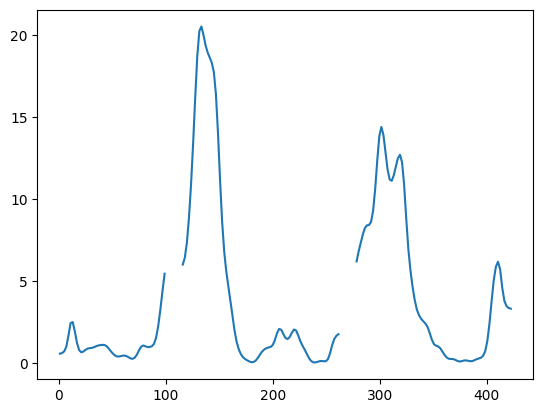

In [44]:
plt.plot(env.place_bin_centers_, rate[1] * 500)